# Práctica 1: Aprendizaje automático

__Fecha de entrega: XX de YYY de 2022 (CAMBIAR PARA DAR 3 SEMANAS A CADA GRUPO)__

El objetivo de esta práctica es aplicar los distintos algoritmos de aprendizaje automático disponibles en la scikit-learn [sklearn](https://scikit-learn.org/stable/) sobre varios conjuntos de datos y aprender a interpretar los resultados obtenidos. La práctica consta de 2 notebooks que se entregarán simultáneamente en la tarea de entrega habilitada en el Campus  Virtual.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

# Apartado 1: Clustering


__Nombres de los estudiantes: Enrique Queipo de Llano y Alejandro Paz Olalla__

In [1]:
# acceso a google drive

#from google.colab import drive
#drive.mount('/content/drive')

## 1) Carga del conjunto de datos

Crea un dataframe a partir del fichero `Mall_Customers.csv` que se proporciona junto con la práctica. 

El conjunto de datos contiene por cada fila los datos de un préstamo que fue concedido por una empresa de crédito p2p. Las variables que caracterizan el préstamo son las siguientes:
  - `Customer ID` es el identificador del cliente
  - `Gender` es el género del cliente (Male|Female)
  - `Annual Income` son los ingresos anuales en cientos de dólares del cliente
  - `Age` es la edad del cliente
  - `Spending Score` es una puntuación asignada por el mall basada en el comportamiento del cliente y a sus gastos

In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler,StandardScaler

plt.rcParams['figure.figsize'] = (16, 8)
RANDOM_STATE = 333

df = pd.read_csv('Mall_Customers.csv', index_col = 0)
df.head()

Gender  Age  Annual Income (k$)  Spending Score (1-100)
CustomerID                                                         
1             Male   19                  15                      39
2             Male   21                  15                      81
3           Female   20                  16                       6
4           Female   23                  16                      77
5           Female   31                  17                      40

In [3]:
df.shape

(200, 4)

In [4]:
# Renombramos algunas columnas por conveniencia
df = df.rename(columns = {'CustomerID':'ID','Annual Income (k$)':'Income','Spending Score (1-100)': 'Spending','Genre':'Gender'} )
df.head()

Gender  Age  Income  Spending
CustomerID                               
1             Male   19      15        39
2             Male   21      15        81
3           Female   20      16         6
4           Female   23      16        77
5           Female   31      17        40

In [5]:
# get information about data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Gender    200 non-null    object
 1   Age       200 non-null    int64 
 2   Income    200 non-null    int64 
 3   Spending  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


## 2) Análisis de los datos

### 2.1) Numéricos

Analiza razonadamente las distribuciones de cada una de las variables numéricas (medias, desviaciones típicas, rangos, ...) y las principales relaciones entre pares de variables (diagrama de dispersión, coeficientes de correlación, ...).

In [6]:
#Primero observamos los estadísticos
df.describe()

Age      Income    Spending
count  200.000000  200.000000  200.000000
mean    38.850000   60.560000   50.200000
std     13.969007   26.264721   25.823522
min     18.000000   15.000000    1.000000
25%     28.750000   41.500000   34.750000
50%     36.000000   61.500000   50.000000
75%     49.000000   78.000000   73.000000
max     70.000000  137.000000   99.000000

Observamos que el rango de edades en el dataset es de los 18 a los 70, con una media de 39 años. En cuanto a los ingresos (en miles de dólares), el rango es desde los 15 hasta los 137 y en la puntuación de gasto, tenemos números en una escala del 1 al 100 que parecen estar distribuidos más o menos acordes a la normal con media de 50 y desviación típica de 26.

In [7]:
#Y la correlación entre las variables
df.corr()

Age    Income  Spending
Age       1.000000 -0.012398 -0.327227
Income   -0.012398  1.000000  0.009903
Spending -0.327227  0.009903  1.000000

Observamos una correlación casi nula entre las variables salvo entre `Age` y `Spending`, entre las cuales observamos una correlación aproximada de -0.33. Esto quiere decir que existe una débil relación linear entre dichas variables.

<AxesSubplot:title={'center':'Age'}, xlabel='Age', ylabel='count'>

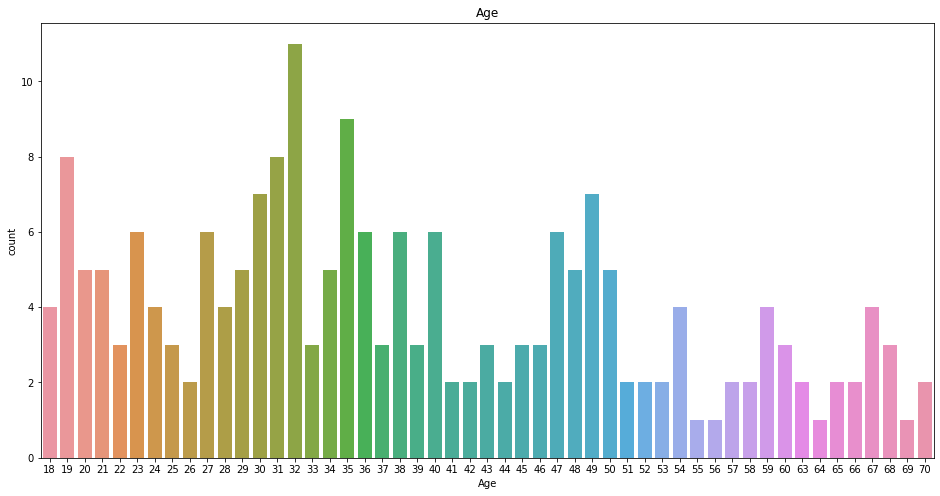

In [8]:
#Visualizamos la distribución de edades de nuestro dataset
plt.title("Age")
sns.countplot(x='Age',data=df)

En nuestro dataset contamos con un mayor número de datos de personas entre los 18 y los 40 años que de personas mayores de 50 años. Podríamos segmentar las edades en tres grupos, que graficamos a continuación:

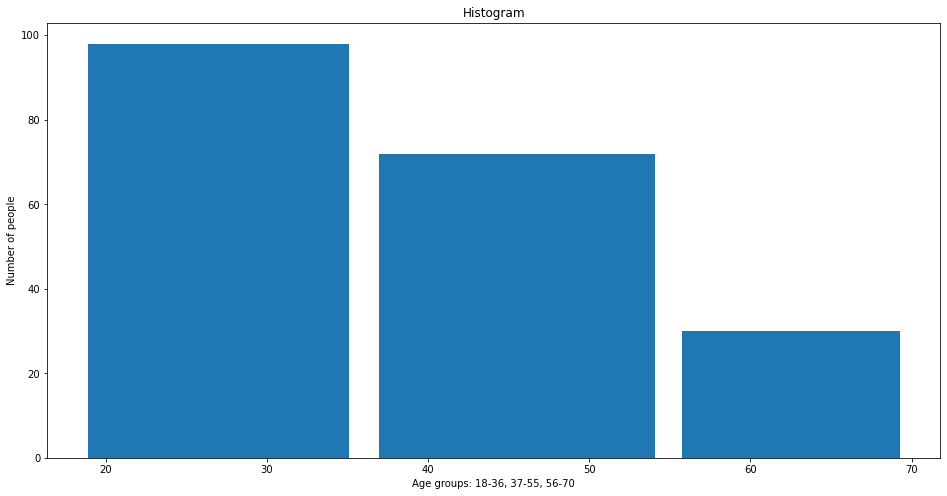

In [9]:
bins = [18,36,55,70]
plt.hist(df['Age'], bins=bins, histtype='bar',rwidth=0.9)
plt.xlabel('Age groups: 18-36, 37-55, 56-70')
plt.ylabel('Number of people')
plt.title('Histogram')
plt.show()

<AxesSubplot:title={'center':'Annual Income vs Spending Score '}, xlabel='Income', ylabel='Spending'>

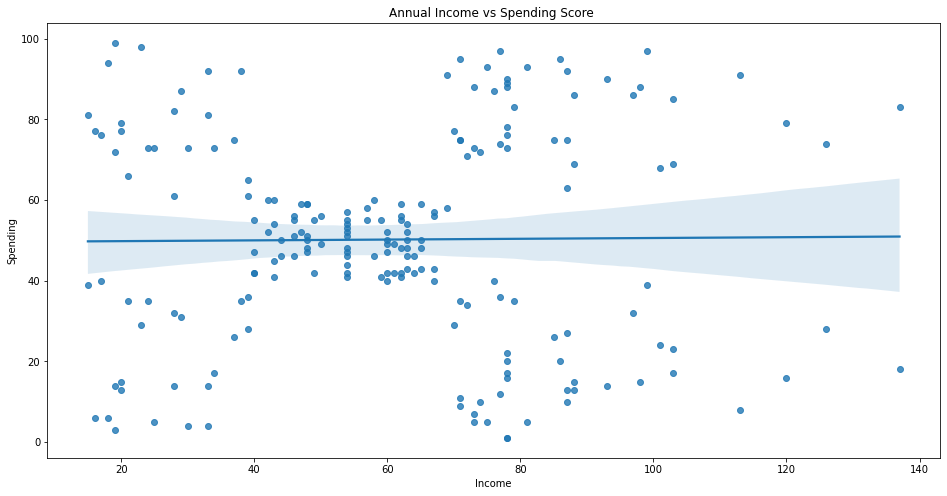

In [10]:
plt.title('Annual Income vs Spending Score ')
sns.regplot(x='Income',y='Spending',data=df)

Uno podría esperar que los ingresos y los gastos estuvieran relacionados, es decir, que a mayores ganancias mayor gasto. Sin embargo, en esta última gráfica podemos observar que la correlación entre las variables es prácticamente cero (0.009), por lo que no existe una relación lineal fuerte entre el ingreso y el gasto. Parece que podemos observar lo que serían 5 grupos o clústers dinstintos. Más adelante veremos que este será el número óptimo de clusters para las K-Medias. Dado que `Spending` es una escala del 1 al 100 e `Income` aproximadamente del 15 al 140, intuitivamente cuando escalemos los datos, el eje X de esta gráfica se "encogerá", acercando los puntos, pero deberían (de nuevo, intuitivamente) seguir saliendo 5 clústers aunque escalemos.

A continuación, añadimos también gráficas para comparar también los gastos e ingresos con la edad.

<AxesSubplot:title={'center':'Age vs Annual Income'}, xlabel='Age', ylabel='Income'>

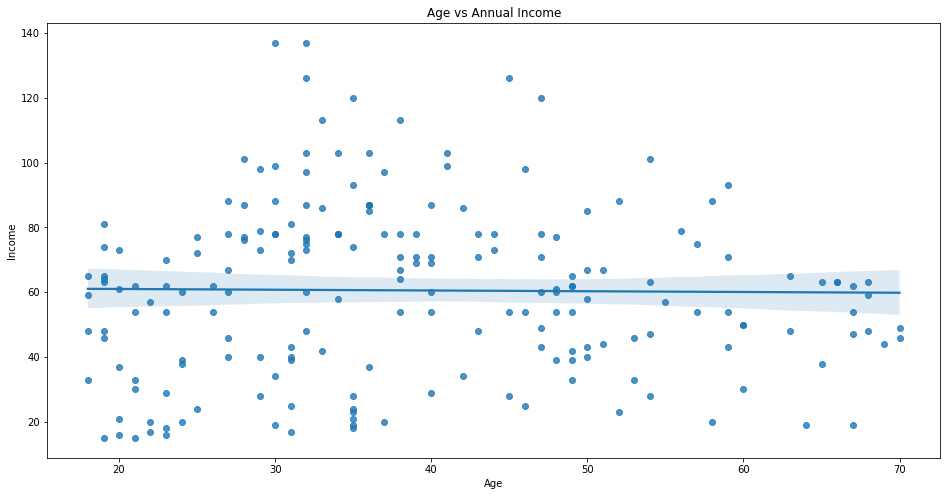

In [11]:
plt.title('Age vs Annual Income')
sns.regplot(x='Age',y='Income',data=df)

<AxesSubplot:title={'center':'Age vs Spending Score '}, xlabel='Age', ylabel='Spending'>

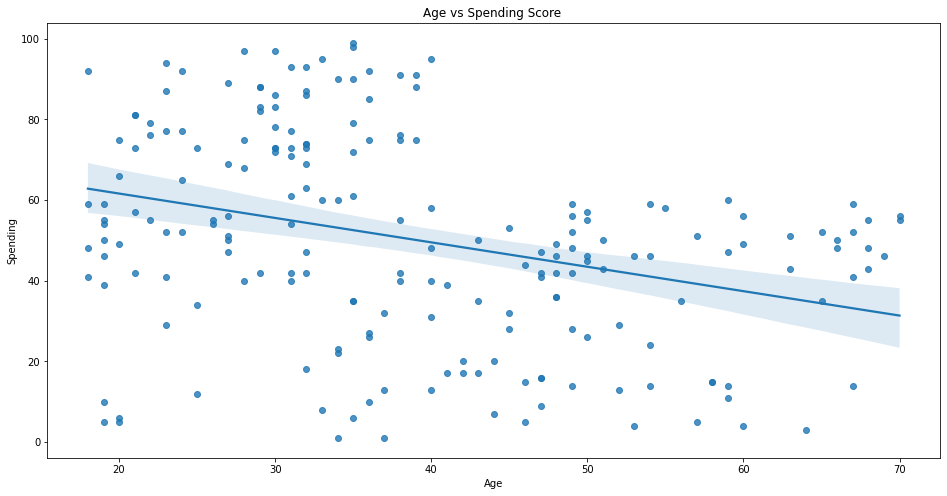

In [12]:
plt.title('Age vs Spending Score ')
sns.regplot(x='Age',y='Spending',data=df)

En esta última gráfica podemos observar la débil relación lineal de la que hablábamos previamente.

A continuación, vamos a condensar todo esto en una matriz de gráficas que también indique  si los individuos son hombre/mujer. Así, podremos observar también si la variable `Gender` nos da información, ya que uno podría pernsar, por ejemplo, que las mujeres gastan más en un centro comercial que los hombres.

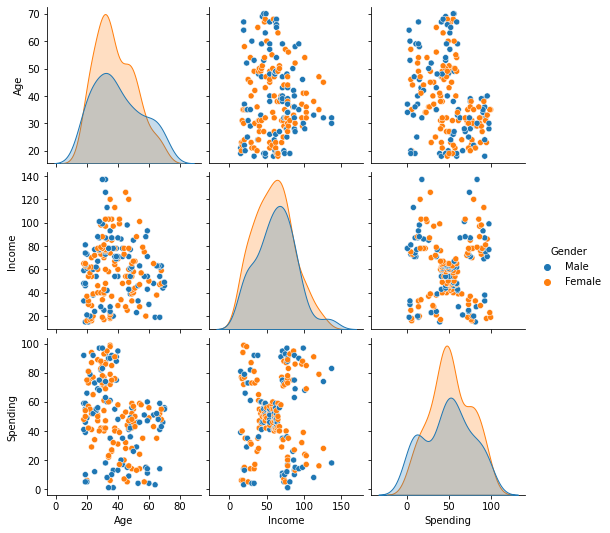

In [13]:
sns.pairplot(df, hue = "Gender")

Como habíamos comentado, parece lógico que aparezcan 5 clústers viendo las gráficas de Income vs Spending. El género no parece ser distintivo.


### 2.2) Categóricos

Analiza razonadamente las distribuciones de los valores de las variables categóricas incluyendo un diagrama de frecuencias y comentando lo más destacable.

Female    112
Male       88
Name: Gender, dtype: int64

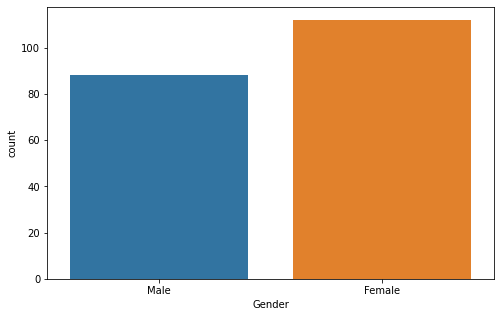

In [14]:
# The number of Genre in the dataset and its graphic.
plt.figure(figsize=(8,5))
sns.countplot(x = "Gender", data = df)
df.loc[:,"Gender"].value_counts()

## 3) Preprocesar los datos

Para el clustering vamos a trabajar solamente con las variables `Annual income`, y `spending score`.

Teniendo en cuenta que vamos a utilizar el algoritmo k-Means para encontrar grupos de clientes similares, explica razonadamente si es necesario o no cambiar la escalas de los datos y si a priori es mejor reescalarlos (MinMaxScaler) o estandarizarlos (StandarScaler).

Si decides preprocesarlos, accede al array interno del dataframe y crea un nuevo array con los datos escalados.

Aunque los rangos de `Spending` están en una escala del 1 al 100, los de `Income` van aproximadamente del 15 al 140, teniendo algunos en el extremo. Por tanto, utilizaremos `MinMaxScaler` para mandar ambas variables al intervalo [0,1]. Tampoco hacemos ningún manejo de datos no nulos ya que no los hay.

In [15]:
df.isna().sum()

Gender      0
Age         0
Income      0
Spending    0
dtype: int64

In [16]:
columnas = ['Age','Income','Spending']
mmscaler = MinMaxScaler()
df_scaled =pd.DataFrame(mmscaler.fit_transform(df[columnas]),columns=columnas)
df_scaled.head()

Age    Income  Spending
0  0.019231  0.000000  0.387755
1  0.057692  0.000000  0.816327
2  0.038462  0.008197  0.051020
3  0.096154  0.008197  0.775510
4  0.250000  0.016393  0.397959

In [17]:
X = df_scaled.iloc[0:,1:]
X.head()

Income  Spending
0  0.000000  0.387755
1  0.000000  0.816327
2  0.008197  0.051020
3  0.008197  0.775510
4  0.016393  0.397959

## 4) Encontrar el número óptimo de clusters

Decide razonadamente el número óptimo de clusters en el rango 2..10. Ten en cuenta que para interpretar los datos no nos interesa tampoco tener un número excesivo de clusters. Para hacerlo calcula y pinta el diagrama del codo y el índice davies_bouldin en función del número de clusters.

In [18]:
def plot_clusters(X, labels=None, centers=None):
    """ Función auxiliar para pintar los puntos de los clusters y, optativamente, sus centros.
    :param X: array de puntos de dos dimensiones (array de array de enteros)
    :param labels: cluster al que pertenece cada punto (array de enteros)
    :param centers: coordenadas de los centroides de los clusters (array de array de enteros)
    """
    
    colors = ['r','g','b','c','y','k','m',]
    fig = plt.figure(figsize=(8,8))
    
    # Los dos primeros parámetros de la función scatter son las coordenadas de los puntos,
    # el parámetro 'c' indica la clase asignada de cada punto, y 'cmap' se usa para colorear 
    # las distintas clases
    plt.scatter(X[:,0], X[:,1], c=labels, cmap=ListedColormap(colors))
    
    # Pintar los centroides de los clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], marker="x", color='k', s=150, linewidths = 5, zorder=10)
        
    plt.show()

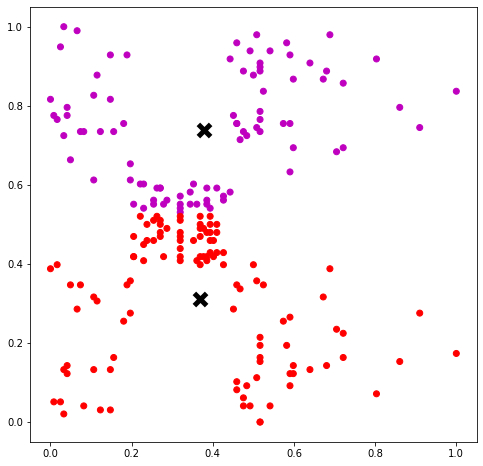

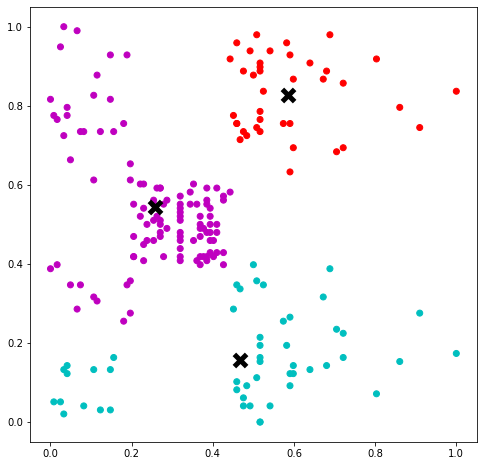

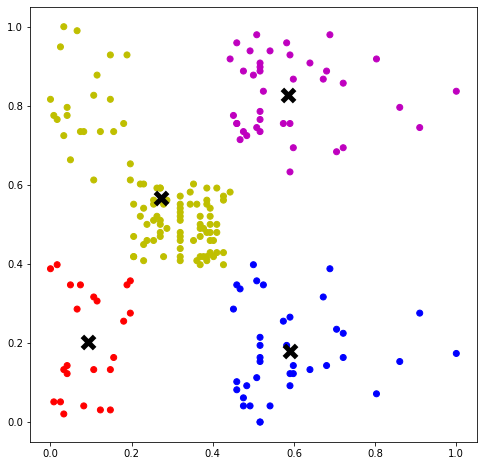

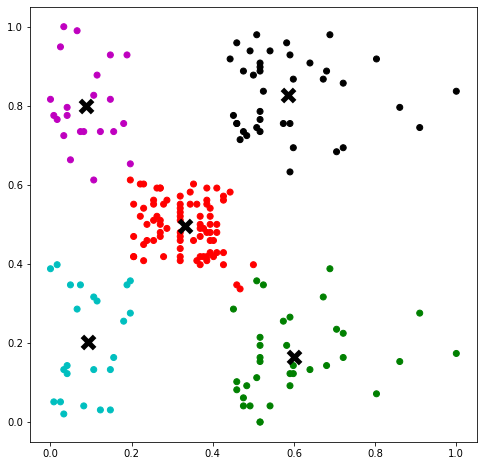

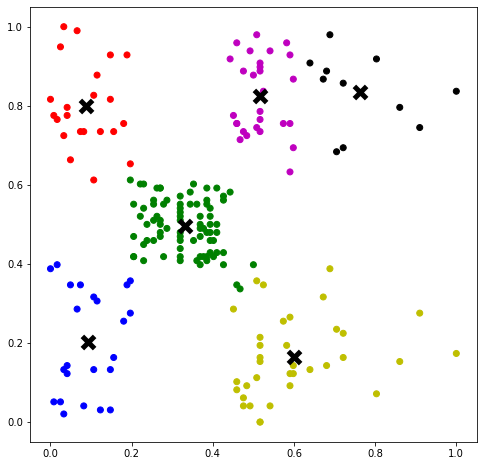

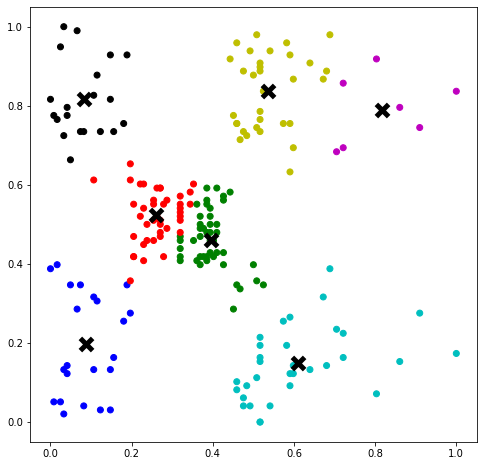

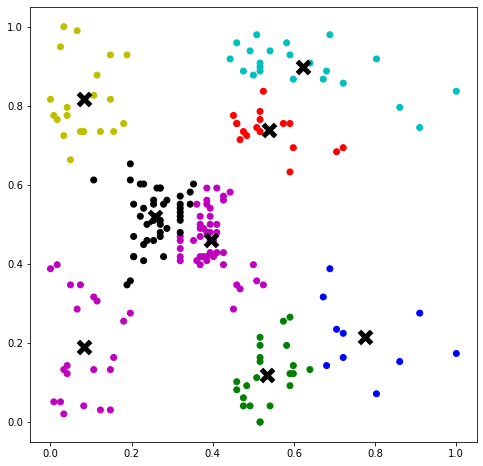

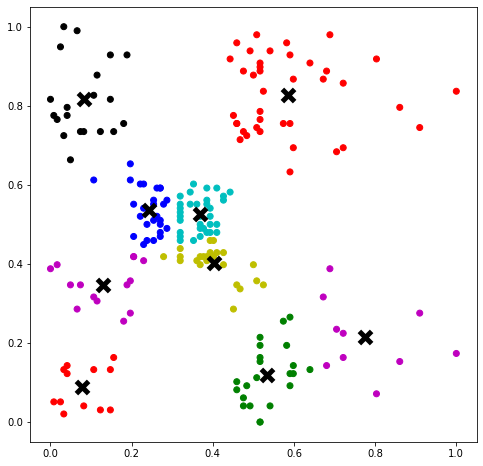

In [19]:
#Para cada k, calculamos la media de las distancias intra-cluster o la Within-Cluster Sum of Squares (WCSS)
K_MAX = 10
wcss = []
davies_bouldin = np.zeros(K_MAX-2)
for k in range(2,K_MAX):
    km = KMeans(init='random',n_clusters=k,n_init='auto',random_state=RANDOM_STATE)
    km.fit(X)
    wcss.append(km.inertia_)
    plot_clusters(X.values, km.labels_, km.cluster_centers_)
    
    davies_bouldin[k-2] = davies_bouldin_score(X, km.labels_) 

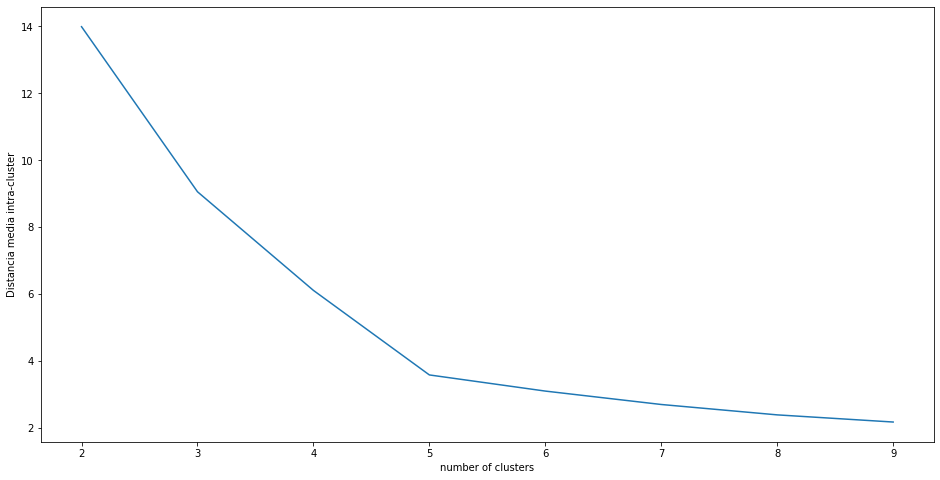

In [20]:
plt.plot(range(2,K_MAX), wcss)
plt.xlabel("number of clusters")
plt.ylabel("Distancia media intra-cluster")
plt.show()

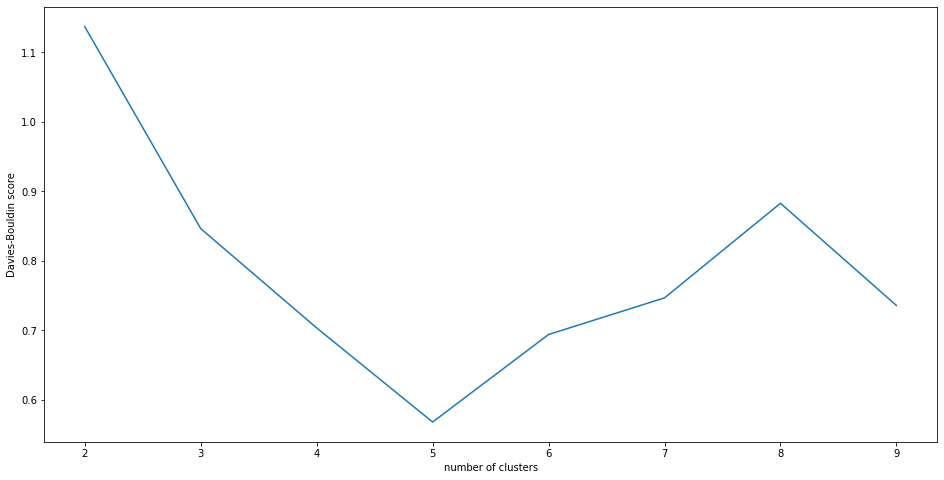

In [21]:
plt.plot(range(2,K_MAX), davies_bouldin)
plt.xlabel("number of clusters")
plt.ylabel("Davies-Bouldin score")
plt.show()

Tanto por el diagrama del codo como por el índice de Davies-Bouldin, podemos concluir que el número óptimo de clústers es k=5, lo cual era acorde con nuestra intuición

## 5) Descripción de los clusters

Describe los clusters que has obtenido en el apartado anterior. Si te han salido más de 5 elige 5 de ellos que sean bastante diferentes entre sí. 

Para hacerlo estudia sus descriptores estadísticos y dales un sentido dentro del contexto del problema. ¿Qué perfil de clientes quedan en cada cluster? 

__Cuidado__: para poder interpretar correctamente los datos necesitas que estén en su escala original. Si decidiste escalar los datos, deberás ejecutar k-Means con los datos escalados pero asignar las etiquetas de clusters al conjunto de datos inicial. En este caso es muy sencillo porque el algoritmo no cambia el orden de los datos así que puedes crear directamente una nueva columna en el dataframe original con esas etiquetas. Puede que aparezca un SettingWithCopyWarning por asignar una nueva columna en un dataframe que es una vista de otro dataframe. Puedes ignorar este aviso o puedes hacer una copia del dataframe con `copy` para que no comparta memoria con el otro.

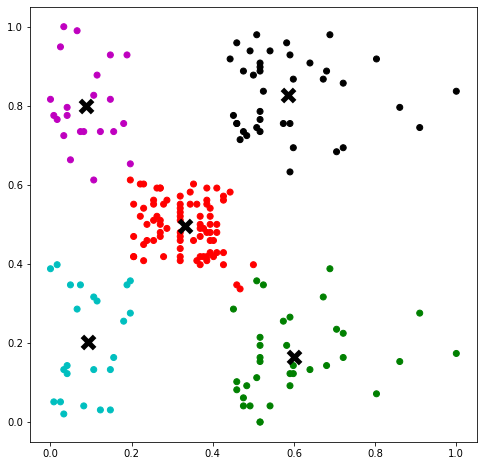

In [22]:
# Crear una instancia del agrupador k-means
km = KMeans(init='random', n_clusters=5,n_init='auto', random_state=333)

# Agrupar los puntos en clusters
km.fit(X)

# Podemos consultar el cluster asignado a cada punto y el centro de cada cluster
labels = km.labels_
centers = km.cluster_centers_

plot_clusters(X.values, labels, centers)

Observando estos cinco grupos, podemos entonces interpretar los clusteres como una segmentación de los clientes en 5 grupos que podrían ser:

-- En negro y rojo aquellos clientes que, con un ingreso entre los 15k y los 40k, gastan poco (menos de 40, negro) o mucho (más de 60, rojo)

-- En color cian, encontramos un grupo muy compacto correspondiente a los clientes que tienen entre 40 y 70 miles de dólares y que gastan en un rango intermedio a los anteriores, esto es, con puntuaciones entre 40 y 60

-- A continuación, encontramos clientes con un alto ingreso mayor a los 70 mil dólares. Estos, a su vez, se dividen en otros dos clústers que representan a los que gastan mucho (verde) y a los que gastan poco (morado). Quizás se deba a que el centro comercial tiene clientes con buena situación económica, pero que son modestos en sus compras, así como clientes con buena situación económica y que gastan en artículos de lujo.

Es curioso observar que, ni los que ganan "mucho" ni los que ganan "poco", gastan moderadamente en el centro comercial. Sólo gastan moderadamente los que cobran moderadamente (entendiendo moderadamente como el rango intermedio entre los altos y los bajos)

In [23]:
df_cluster = df.assign(cluster=pd.Series(data=km.labels_))
df_cluster.head()

Gender  Age  Income  Spending  cluster
CustomerID                                        
1             Male   19      15        39      4.0
2             Male   21      15        81      2.0
3           Female   20      16         6      4.0
4           Female   23      16        77      2.0
5           Female   31      17        40      4.0

Podemos obtener una descripción buena directamente con pandas 

In [24]:
df_cluster.groupby(["cluster"]).describe().transpose()

cluster               0.0         1.0        2.0         3.0        4.0
Age      count  81.000000   35.000000  22.000000   39.000000  22.000000
         mean   42.802469   32.657143  25.590909   40.384615  45.090909
         std    16.435799    3.749062   5.386571   11.226415  13.525669
         min    18.000000   27.000000  18.000000   19.000000  19.000000
         25%    27.000000   30.000000  21.250000   34.000000  35.250000
         50%    47.000000   32.000000  23.500000   41.000000  45.500000
         75%    54.000000   35.500000  30.000000   47.000000  53.750000
         max    70.000000   40.000000  35.000000   59.000000  67.000000
Income   count  81.000000   35.000000  22.000000   39.000000  22.000000
         mean   54.888889   86.342857  25.727273   86.538462  25.727273
         std     8.961027   14.262132   7.566731   16.312485   7.566731
         min    39.000000   69.000000  15.000000   69.000000  15.000000
         25%    48.000000   77.000000  19.250000   75.500000  19.250000
         50%    54.000000   81.000000  24.500000   79.000000  24.500000
         75%    62.000000   95.000000  32.250000   95.000000  32.250000
         max    75.000000  126.000000  39.000000  137.000000  39.000000
Spending count  81.000000   35.000000  22.000000   39.000000  22.000000
         mean   50.975309   82.142857  79.181818   19.641026  20.227273
         std     8.811889    9.604358  10.795221   12.480484  12.891237
         min    36.000000   63.000000  61.000000    1.000000   3.000000
         25%    46.000000   74.000000  73.000000   10.500000   7.750000
         50%    50.000000   85.000000  77.000000   17.000000  16.000000
         75%    55.000000   90.000000  85.750000   27.500000  31.750000
         max    93.000000   97.000000  99.000000   58.000000  40.000000

Incluso visualizar la distribución de sus variables

cluster
0.0    AxesSubplot(0.125,0.125;0.775x0.755)
1.0    AxesSubplot(0.125,0.125;0.775x0.755)
2.0    AxesSubplot(0.125,0.125;0.775x0.755)
3.0    AxesSubplot(0.125,0.125;0.775x0.755)
4.0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Spending, dtype: object

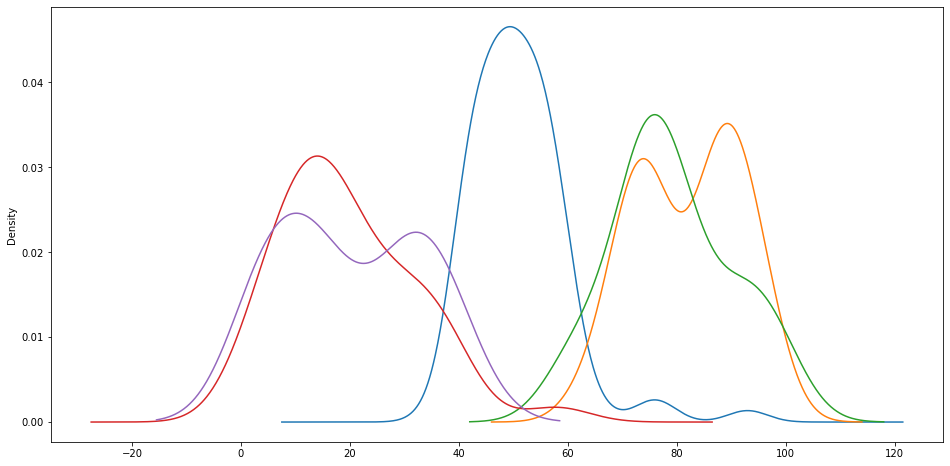

In [25]:
df_cluster.groupby('cluster')["Spending"].plot(kind='kde', ax=plt.gca())

De esta última gráfica, podemos observar lo que comentábamos. Parece haber dos grupos de menor `Spending`, dos grupos con mayores `Spending` y otro de `Spending` medio.

## 6) Clustering jerárquico aglomerativo
Repite los apartados 4 y 5 usando clustering jerárquico aglomerativo.



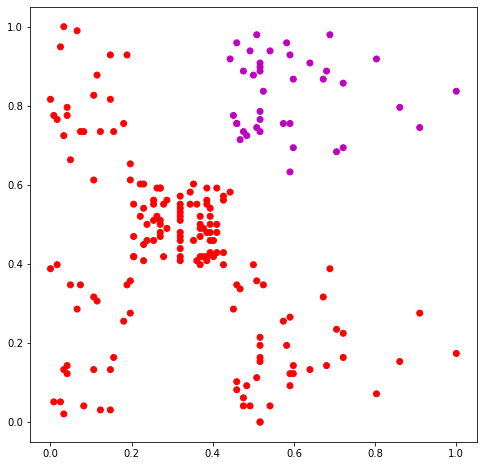

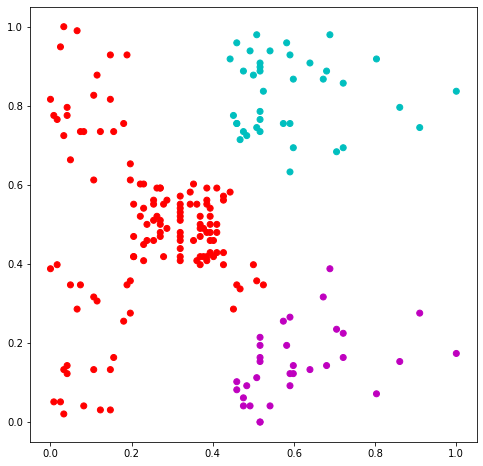

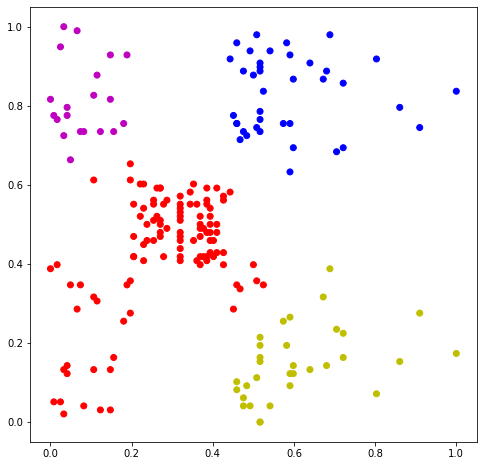

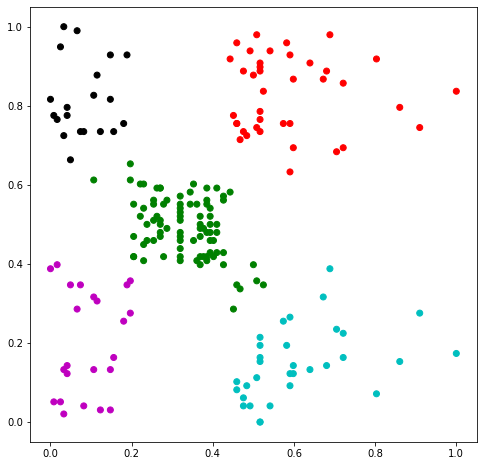

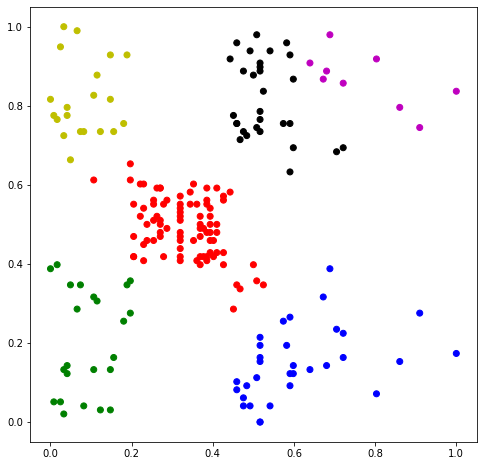

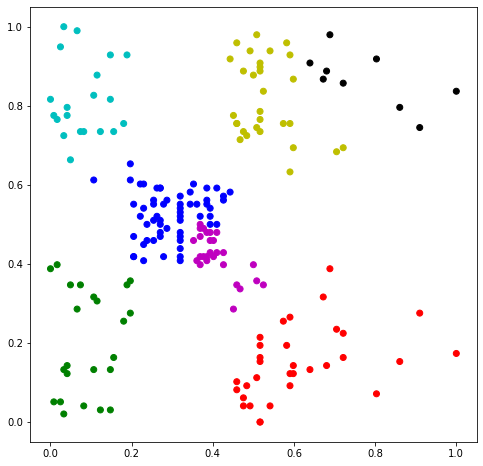

In [26]:
K_MAX = 8
davies_bouldin_ag = np.zeros(K_MAX-2)
for k in range(2, K_MAX): 
    ag = AgglomerativeClustering(n_clusters=k, linkage='ward', metric='euclidean')
    ag.fit(X)
    plot_clusters(X.values, ag.labels_)
    
    davies_bouldin_ag[k-2] = davies_bouldin_score(X, ag.labels_) 

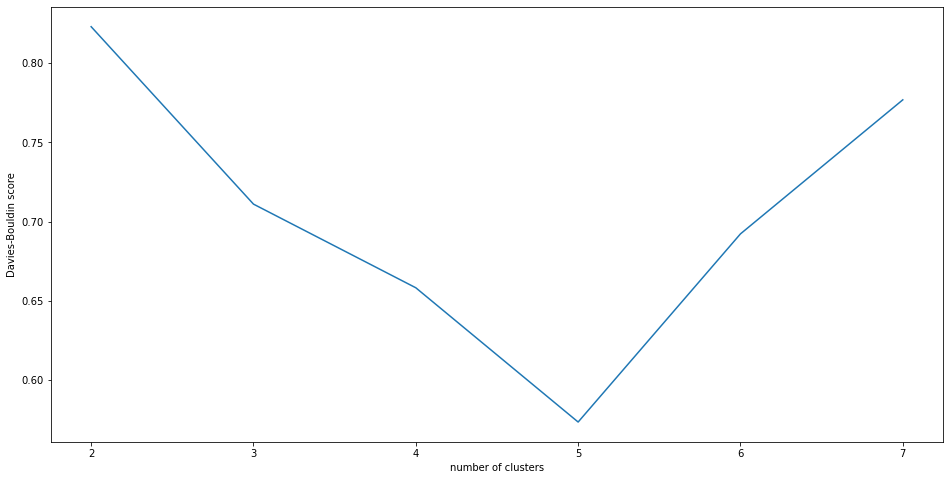

In [27]:
plt.plot(range(2,K_MAX), davies_bouldin_ag)
plt.xlabel("number of clusters")
plt.ylabel("Davies-Bouldin score")
plt.show()

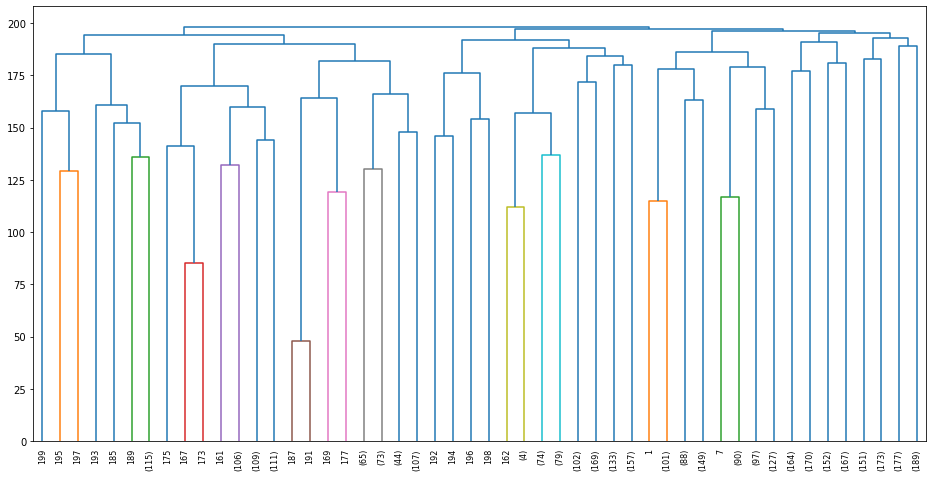

In [28]:
# Sciki-learn no pinta el dendrograma, pero scipy sí, 
# la siguiente función permite usar el modelo ajustado por scikit learn para pintar el dendrograma
# https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    


ag = AgglomerativeClustering(n_clusters=5, linkage='ward', metric='euclidean')
ag.fit(X)

# Dibujar los primeros 5 niveles del árbol
levels = 5
plot_dendrogram(ag, p=levels, truncate_mode='level')

# Árbol completo
#plot_dendrogram(ag)

# HASTA AQUÍ LA PRÁCTICA DE IA2

A continuación, haremos algunos estudios adicionales que podríamos haber incluido en los apartados anteriores, como el test de silueta o clustering mediante DBSCAN. También incluiremos las KMedias teniendo en cuenta la edad y haremos representaciones 3D.

## VALOR DE SILUETA

El valor de silueta de una individuo es (b – a) / max(a, b), donde a es la distancia media a los otros individuos de un mismo cluster (i.e., la distancia media intra-cluster) y b es la distancia media al cluster más cercano (i.e., la distancia media a los individuos del siguiente cluster más cercano).

El valor puede variar entre –1 y +1. Un coeficiente cercano a +1 significa que el individuo está bien dentro de su cluster y lejos de otros clusters, mientras que un coeficiente cercano a cero significa que es cercano a la fronter de un cluster, y finalmente, un coeficiente cercano a –1 significa que el individuo puede haber sido asignado a un cluster erróneo.


Para calcular el valor de silueta, podemos utilizar el método silhouette_score() de ScikitLearn

In [29]:
from sklearn.metrics import silhouette_score

In [30]:
sil_scores = []
for k in range(2,K_MAX):
    km = KMeans(init='random',n_clusters=k,n_init='auto',random_state=333)
    km.fit(X)
    sil_score=silhouette_score(X.values,km.labels_)
    sil_scores.append(sil_score)

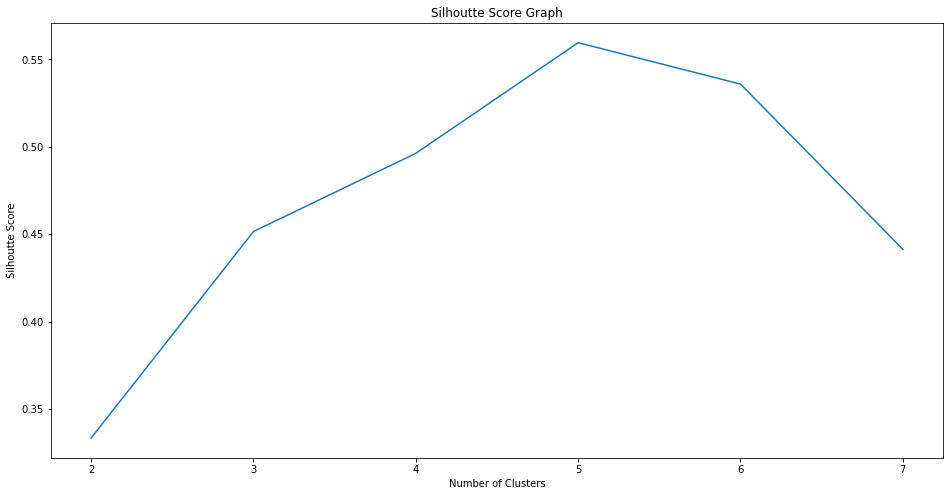

In [31]:
# Plotting Silhoutte graph
# Remember Silhoutte score closest to +1, provides the optimal k value

plt.plot(range(2,K_MAX), sil_scores)
plt.title('Silhoutte Score Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhoutte Score')
plt.show()

De nuevo podemos observar y confirmar que el número óptimo de clusters era de 5

## DBSCAN CLUSTERING

DBSCAN son las siglas de Clustering Escpacial Basado en Densidades de Aplicaciones con Ruido (Density-Based Spatial Clustering of Applications with Noise).

El algoritmo se basa en la asunción de que los clusters son regiones densas en el espacio separadas por otras regiones de menor densidad.

Puede identificar clusters en un amplio rango de datasets mirando las densidades locales de los puntos.

La propiedad más importante de DBSCAN es que es robusto frente a "outlier" o valores atípicos.

A diferencia de las K-Medias, DBSCAN no necesita el número de clusters como parámetro.

DBSCAN requiere sólo dos parámetros: epsilon y minPoints / minSamples.

__epsilon__: es el radio del círculo que se creará en torno a cada punto para calcular la densidad.

__minPoints__: es el número mínimo de putos de datos requeridos dentro de ese círculo para que el punto sea clasificado como un "Core point" o punto esencial

Classification of data points:

--Core points  
--Boundary points or border points  
--Noise points


Un punto p es un punto núcleo si al menos minPts puntos están a una distancia ε de él y, esos puntos son directamente alcanzables desde p. No es posible tener puntos directamente alcanzables desde un punto que no sea un núcleo.

Un punto q es alcanzable desde p si existe una secuencia de puntos p_1,..,p_n con p_1 = p, p_n = q tal que cada p_i+1 es directamente alcanzable desde p_i; es decir, todos los puntos de la secuencia deben ser puntos núcleos, con la posible excepción de q.

Un punto que no sea alcanzable desde cualquier otro punto es considerado ruido

__Cómo elegir los parámetros__

MinPts: Como regla general, un MinPts mínimo se pueden derivar de la serie de dimensiones D en el conjunto de datos, como minPts ≥ D+1. El valor de MinPts = 1 no tiene sentido, ya que todos los puntos de su cluster serán un clúster. Con MinPts = 2, el resultado será el mismo que el de la agrupación jerárquica con la métrica single-link, con el corte a la altura del dendrograma _e_. Sin embargo, los valores más grandes son generalmente mejores para los conjuntos de datos con ruido y rendirán agrupaciones más importantes. Cuanto más grande es el conjunto de datos, mayor será el valor de MinPts elegido.

e: El valor para _e_ entonces puede ser elegido por el uso de un gráfico k-distancia, el trazado de la distancia a la k = MinPts vecino más cercano. Buenos valores de _e_ son donde este gráfico muestra una fuerte curvatura: si _e_ es elegido demasiado pequeño, no se agrupan una gran parte de los datos; mientras que para un muy alto valor de _e_, las agrupaciones se fusionan y la mayoría de los objetos serán en el mismo grupo.

In [32]:
from sklearn.cluster import DBSCAN

#Need to scale the data in order to use a reasonable number for epsilon
X_scaled = StandardScaler().fit_transform(X)
#Apply DBSCAN
db = DBSCAN(eps=0.4, min_samples=5).fit(X_scaled)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 15


In [33]:
print(f"Silhouette Coefficient: {silhouette_score(X, labels):.3f}")

Silhouette Coefficient: 0.417


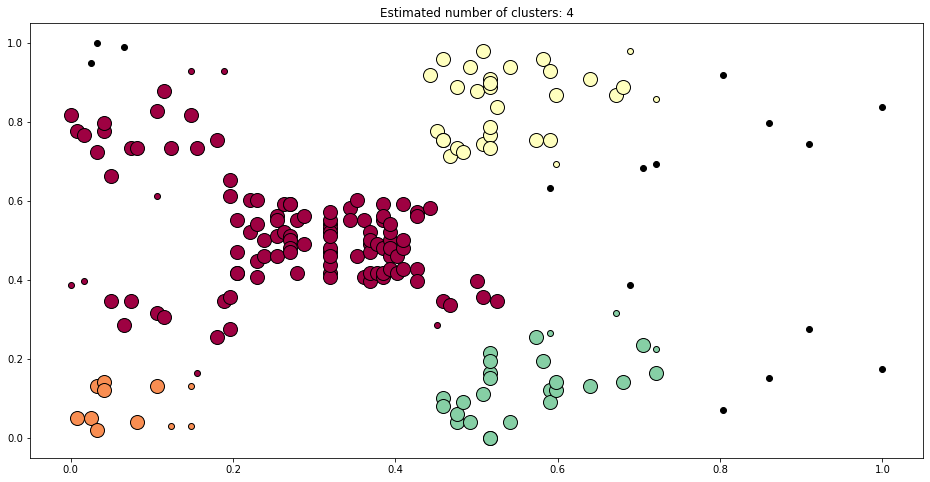

In [34]:
# FROM SKLEARN'S EXAMPLES
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X.values[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X.values[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

Nuestro conjunto de datos contiene ruido y los clusters que reconocemos "a simple vista" no son zonas muy densas (salvo el central). Hemos usado epsilon = 0.4 y minPts = 5 para obtener estos resultados medinate DBSCAN sobre los datos ya escalados

## KMedias, ahora con edad

In [35]:
import plotly.express as px
fig = px.scatter_3d(df, x='Income', y='Spending', z='Age',color='Gender')
fig.show()

No haremos mucho caso del género, nos quedamos con los tres ejes para calcular el número óptimo de clusters. Proyectando sobre {z=0}, esto es "mirando desde arriba", podemos observar la gráfica que teníamos originalmente de `Income` vs `Spending`

In [36]:
X_edad = df.iloc[:,1:]
X_edad.head()

Age  Income  Spending
CustomerID                       
1            19      15        39
2            21      15        81
3            20      16         6
4            23      16        77
5            31      17        40

In [37]:
wcss_3d = []
K_MAX_EDAD = 10
davies_bouldin_3d = np.zeros(K_MAX_EDAD-2)
for k in range(2,K_MAX_EDAD):
    km = KMeans(init='random',n_clusters=k,n_init='auto',random_state=333)
    km.fit(X_edad)
    wcss_3d.append(km.inertia_)
    davies_bouldin_3d[k-2] = davies_bouldin_score(X_edad, km.labels_)

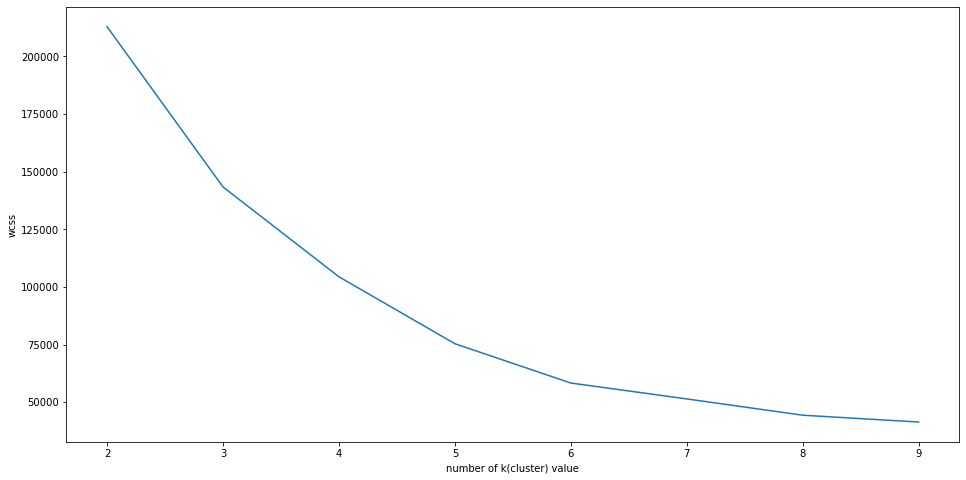

In [38]:
plt.plot(range(2,K_MAX_EDAD), wcss_3d)
plt.xlabel("number of k(cluster) value")
plt.ylabel("wcss")
plt.show()

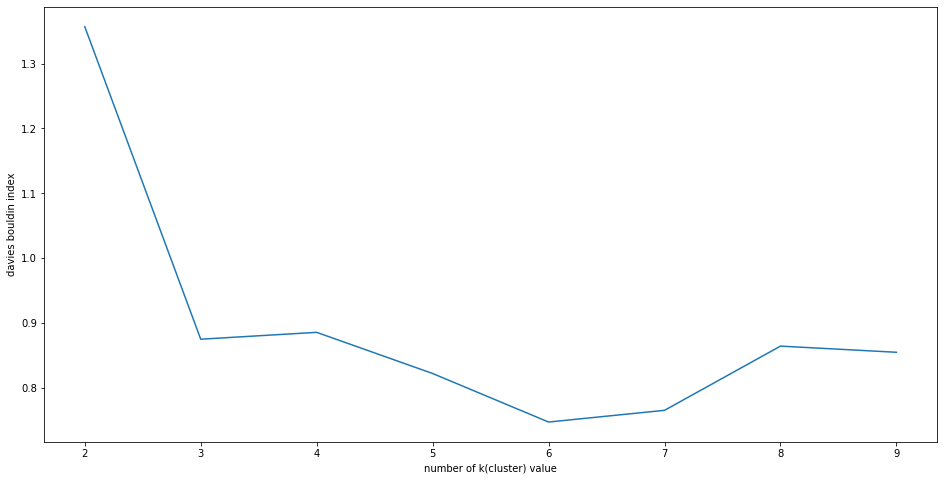

In [39]:
plt.plot(range(2,K_MAX_EDAD), davies_bouldin_3d)
plt.xlabel("number of k(cluster) value")
plt.ylabel("davies bouldin index")
plt.show()

In [40]:
#We will use k = 6
kms = KMeans(n_clusters = 6, init = 'random',n_init='auto',random_state=RANDOM_STATE)
kcluster = pd.DataFrame(kms.fit_predict(X_edad), columns = ["kcluster"])
X_edad["cluster"] = kcluster

In [41]:
fig = px.scatter_3d(X_edad, x = "Spending", y = "Income", z = "Age",
                        hover_data = ["Age"], color = "cluster",
                    title = f"K-Means Clustering (Clusters = {6})  Spending Score,  Annual Income,  Age")

fig.update_coloraxes(showscale = False)
fig.show()

### Conclusión

Como conclusión, parece que podemos ver 4 grupos diferenciado a los "extremos" del diagrama. En naranja, rojo, morado y magenta, parece que podemos observar los 4 grupos de los que también hablábamos en el caso 2-dimensional, es decir, los cuatro grupos son las combinaciones entre ganar poco-mucho y gastar poco-mucho. Podemos extraer de este gráfico que los grupo morado (que gasta mucho y gana poco) y magenta (que gasta mucho y gana mucho) están formados por gente más joven que los otros grupos, por lo que se podría pensar que la gente joven gasta más en el centro comercial. Los grupos naranja y rojo, correspondientes a los que gastan poco, sí tienen un rango de edades más amplio. Por último, contamos ahora con dos grupo centrales (amarillo y azul), que parecen cercanos, y que cuentan con un rango amplio de personas de distintas edades que tienen un sueldo medio y un spending también medio.

Este último clúster no parece del todo normal, ya que parece ser que debería ser solamente uno. Como posibles problemas, puede ser que algo tenga que ver el escalado.